In [2]:
def describe_1darray(array1d):
    df_describe = pd.DataFrame(array1d)
    return df_describe.describe()

In [300]:
## Load modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import xarray as xr 
from scipy import ndimage
import pickle
from metpy.interpolate import cross_section

import sys
sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
from data_preprocessing_helpers import get_cross_section_data

### Goal of this script
- Take a mask around the edge of the below-cloud-process field (with a defined threshold)
- Apply mask to other variables to get statistics how these values vary at the boundary of the bcp-fields

$\rightarrow$ The goal is to find suitable threshold values for SIWC, RWC, RH_ifs (and possibly other variables) to find where the bcp-processes happen

In [240]:
## Load data
ds_p = xr.open_mfdataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/P_p*_lonlatbox.nc')
ds_s = xr.open_mfdataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/S_p*_lonlatbox.nc')
ds_cc = xr.open_mfdataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/additional_fields/CC_p*.nc')
da_rh = xr.open_dataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/additional_fields/RH_ifs.nc')
# Get rid of last timestep (since this one is missing in ds_p)
da_rh = da_rh.isel(time=slice(0,-1))*100

ds_p['tsubsi'] = ds_p['tsubi'] + ds_p['tsubs']
ds_p['tmeltsi'] = ds_p['tmelti'] + ds_p['tmelts']
ds_p['SIWC'] = ds_p['IWC'] + ds_p['SWC']


In [197]:
def get_bcp_mask(data, cooling_threshold=-0.01, dimension=3,):
    # Check if the dimensions are in the correct order
    if data.dims != ('time', 'level', 'lat', 'lon'):
        raise ValueError("The input dataset dimensions should be in the order ('time', 'level', 'lat', 'lon')")

    # Create a binary mask of non-zero tsubS values
    tsubS_mask = (data < cooling_threshold).astype(int)

    if dimension == 2:
        # Apply the Sobel operator for edge detection
        sobel_x = ndimage.sobel(tsubS_mask, axis=1)  # Gradient along the X-axis
        sobel_y = ndimage.sobel(tsubS_mask, axis=2)  # Gradient along the Y-axis
        # Calculate the magnitude of the gradient
        sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    
    elif dimension ==3:
        # Apply the Sobel operator for edge detection
        sobel_x = ndimage.sobel(tsubS_mask, axis=1)  # Gradient along the X-axis
        sobel_y = ndimage.sobel(tsubS_mask, axis=2)  # Gradient along the Y-axis
        sobel_z = ndimage.sobel(tsubS_mask, axis=3)  # Gradient along the Z-axis
        # Calculate the magnitude of the gradient
        sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2 + sobel_z ** 2)

    # Create a binary mask of edges
    edge_mask = (sobel_magnitude > 0).astype(int)
    return edge_mask



def create_bcp_threshold_df(cooling_thresholds=[], bcp='tsubsi', temp_range=None):    
    # Create an empty DataFrame to store statistics for each threshold
    df_stats_siwc = pd.DataFrame()
    df_stats_rh = pd.DataFrame()

    if temp_range is not None:
        temp = ds_p['T']
        if temp_range == 'warm':
            print('Warm temperature range')
            temp_mask = (temp >= 0)
        elif temp_range == 'mix':
            print('Mixed temperature range')
            temp_mask = (temp > -23) & (temp < 0)
        elif temp_range == 'cold':
            print('Cold temperature range')
            temp_mask = (temp <= -23)
        else:
            raise ValueError("Invalid temperature range. Choose 'warm', 'mix', or 'cold'.")
        masked_ds_p = ds_p.where(temp_mask, np.nan)
        masked_da_rh = da_rh.where(temp_mask, np.nan)
    else:
        print('No temperature range was selected')
        masked_ds_p = ds_p
        masked_da_rh = da_rh

    for thr in cooling_thresholds:
        print(f'Threshold: {thr}')
        edge_mask = get_bcp_mask(data=masked_ds_p[bcp], cooling_threshold=thr)
        # Convert 0 values in mask to NaN
        edge_mask=edge_mask.astype('float')
        edge_mask[edge_mask==0] = np.nan

        # Apply mask to RH_ifs and SIWC fields
        bcp_edge_rh = edge_mask * masked_da_rh['RH_ifs']
        bcp_edge_rh_array = bcp_edge_rh.values.flatten()
        bcp_edge_siwc = edge_mask * masked_ds_p['SIWC']
        bcp_edge_siwc_array = bcp_edge_siwc.values.flatten()

        # Create a DataFrame from the bcp_edge_siwc_array and calculate its statistics
        siwc_stats_df = pd.DataFrame(bcp_edge_siwc_array, columns=[f'thr = {thr}'])
        siwc_stats = siwc_stats_df.describe()
        siwc_stats.loc['90%'] = siwc_stats_df.quantile(0.9)  # Add 90th percentile
        siwc_stats.loc['99%'] = siwc_stats_df.quantile(0.99)  # Add 99th percentile
        siwc_stats.loc['10%'] = siwc_stats_df.quantile(0.1)  # Add 90th percentile
        siwc_stats.loc['01%'] = siwc_stats_df.quantile(0.01)  # Add 99th percentile

        rh_stats_df = pd.DataFrame(bcp_edge_rh_array, columns=[f'thr = {thr}'])
        rh_stats = rh_stats_df.describe()
        rh_stats.loc['90%'] = rh_stats_df.quantile(0.9)  # Add 90th percentile
        rh_stats.loc['99%'] = rh_stats_df.quantile(0.99)  # Add 99th percentile  
        rh_stats.loc['10%'] = rh_stats_df.quantile(0.1)  # Add 90th percentile
        rh_stats.loc['01%'] = rh_stats_df.quantile(0.01)  # Add 99th percentile  
        
        # Append the statistics to the threshold_stats_df
        df_stats_siwc = pd.concat([df_stats_siwc, siwc_stats], axis=1)
        df_stats_rh = pd.concat([df_stats_rh, rh_stats], axis=1)


    return df_stats_siwc, df_stats_rh

In [198]:
cooling_thresholds = [-0.01, -0.05, -0.1, -0.25, -0.5, -0.75, -1,]
df_stats_siwc_warm, df_stats_rh_warm = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tsubsi', temp_range='warm')
df_stats_siwc_mix, df_stats_rh_mix = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tsubsi', temp_range='mix')
df_stats_siwc_cold, df_stats_rh_cold = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tsubsi', temp_range='cold')

Warm temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1
Mixed temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1
Cold temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1


In [199]:
def custom_boxplot(ax, data, label, position):
    stats = data[label]
    box = [stats['25%'], stats['75%']]
    median = stats['50%']
    whiskers = [stats['min'], stats['max']]
    mean = stats['mean']
    percentile_90 = stats['90%']
    percentile_99 = stats['99%']
    percentile_10 = stats['10%']
    percentile_01 = stats['01%']
    
    ax.bxp([{'label': label, 'whislo': whiskers[0], 'q1': box[0], 'med': median, 'q3': box[1], 'whishi': whiskers[1], 'fliers': []}], positions=[position[0]], widths=0.5, zorder=2)
    ax.hlines(mean, position[0]-0.25, position[0]+0.25, colors='green', linestyles='dashed', linewidth=0.75)  # Add mean as dashed line
    img=ax.plot(position[0], percentile_90, marker='o', markersize=6, color='black', label='90th and 10th percentile')
    img=ax.plot(position[0], percentile_99, marker='X', markersize=8, color='black', label='99th and 1st percentile')
    img=ax.plot(position[0], percentile_10, marker='o', markersize=6, color='black')
    img=ax.plot(position[0], percentile_01, marker='X', markersize=8, color='black')
    count_text = f'c: {stats["count"]:.1e}'  # Use scientific notation
    textbox = ax.text(position[0], position[1], count_text, fontsize=10, ha='center', bbox=dict(facecolor='beige', edgecolor='black', boxstyle='round,pad=0.2'))

    return img


In [200]:
def plot_custom_boxplots(siwc_dfs, rh_dfs):
    # Check that input parameters are lists and have the same length
    if not isinstance(siwc_dfs, list) or not isinstance(rh_dfs, list):
        raise ValueError("Both input parameters must be lists.")
    if len(siwc_dfs) != len(rh_dfs):
        raise ValueError("Both input lists must have the same length.")
    
    num_dfs = len(siwc_dfs)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 9), sharex=True)

    current_x = 0
    for df_idx, (siwc_df, rh_df) in enumerate(zip(siwc_dfs, rh_dfs)):
        for i, label in enumerate(siwc_df.columns):
            custom_boxplot(axes[0], siwc_df, label, [current_x + i, 15])#axes[0].get_ylim()[1]])
            #print(f' Here lies an issue: {axes[0].get_ylim()[1]-1}')
        for i, label in enumerate(rh_df.columns):
            custom_boxplot(axes[1], rh_df, label, [current_x + i, 15])
        
        current_x += len(siwc_df.columns)
        
        # Set labels and layouts
        axes[0].set_yscale('log')
        axes[0].set_ylim(bottom=1e-5, top=10)
        axes[0].set_ylabel('SIWC [g/kg]')
        axes[1].set_ylim(bottom=-5, top=150)
        axes[1].set_ylabel('RH_ifs [%]')

        # Plot verticasl lines between dfferent dataframes
        if df_idx < num_dfs - 1:  # Do not plot vertical line for the last dataframe
            axes[0].vlines(current_x - 0.5, ymin=axes[0].get_ylim()[0], ymax=axes[0].get_ylim()[1]+20, color='k', linewidth=2, clip_on=False)
            axes[1].vlines(current_x - 0.5, ymin=-40, ymax=180, color='k', linewidth=2, clip_on=False)


    ## Set subplot tiles
    segment_labels = ['warm', 'mix', 'cold']
    segment_positions = [1/6, 0.5, 5/6]
    for idx, (label, pos) in enumerate(zip(segment_labels, segment_positions)):
        fig.text(pos, 0.505, label, fontsize=14, ha='center', va='center', rotation='horizontal')


    # Add horizontal, light, dotted lines for orientation in the background
    levss = [1e-4, 1e-2, 0.1,1]
    for levs in levss:
        axes[0].hlines(levs, *axes[0].get_xlim(), colors='gray', linestyles='dotted', linewidth=1.5, alpha=0.9, zorder=0)
    levss = [40, 60, 80,100, 120, 140]
    for levs in levss:
        axes[1].hlines(levs, *axes[1].get_xlim(), colors='gray', linestyles='dotted', linewidth=1.5, alpha=0.9)
    
    plt.suptitle('TsubS edge statistics based on different cooling thresholds (in [K/hr])', fontsize=20)
    plt.xticks(range(current_x), [label for df in siwc_dfs for label in df.columns],  rotation=45)
    #plt.legend()
    plt.tight_layout()
    plt.show()


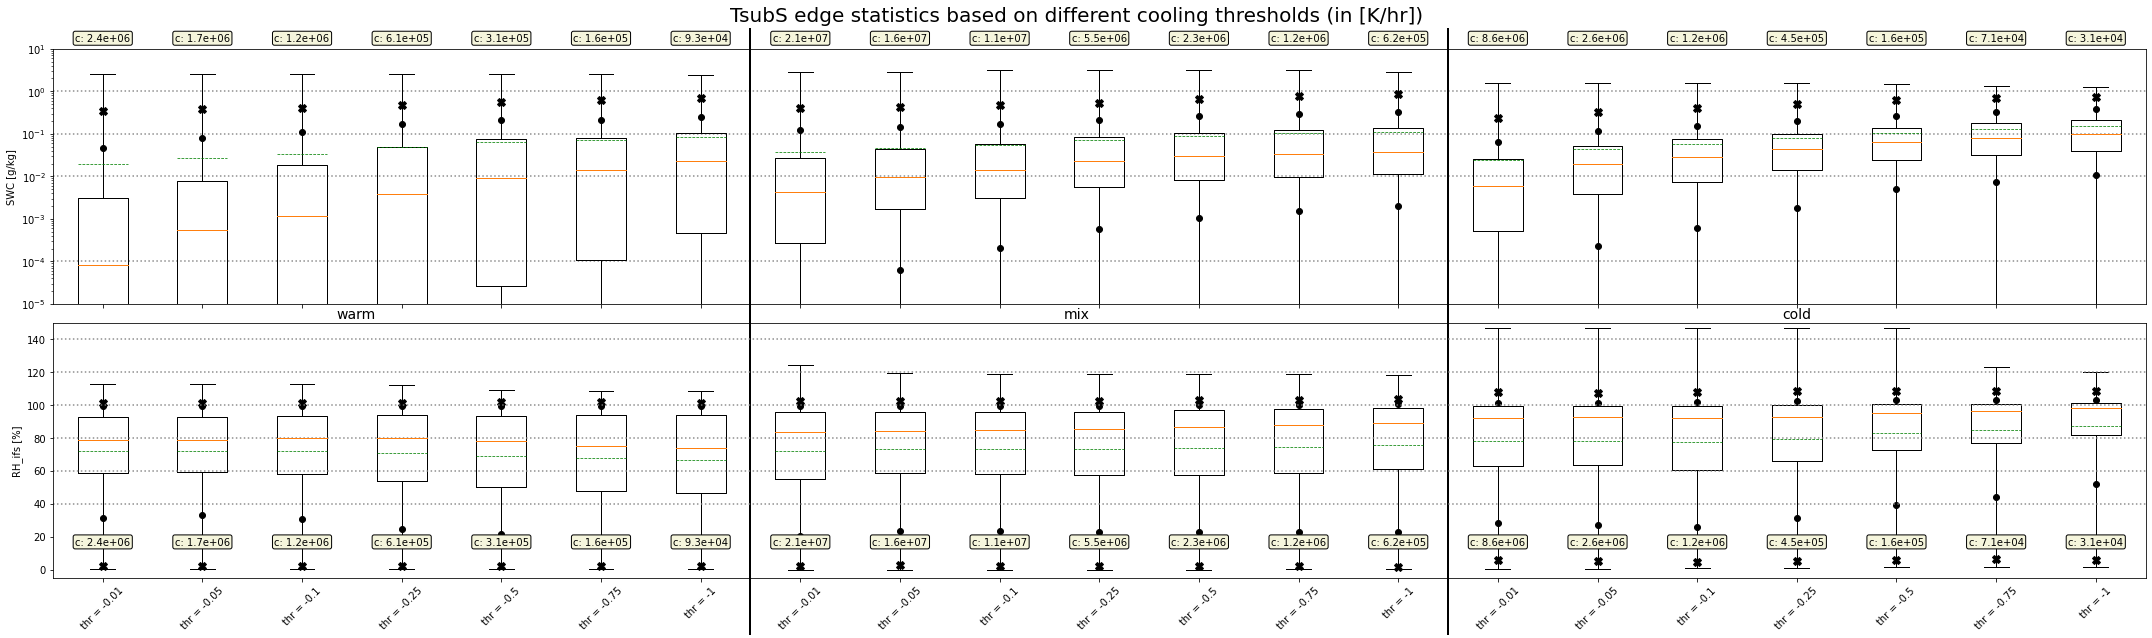

In [201]:
plot_custom_boxplots([df_stats_siwc_warm, df_stats_siwc_mix, df_stats_siwc_cold], [df_stats_rh_warm, df_stats_rh_mix, df_stats_rh_cold])


In [216]:
print(df_stats_siwc_warm['thr = -0.1']['50%'])
print(df_stats_siwc_mix['thr = -0.1']['50%'])
print(df_stats_siwc_cold['thr = -0.1']['50%'])

0.0011874213232658803
0.014149291440844536
0.02888929843902588


In [217]:
print(df_stats_rh_warm['thr = -0.1']['50%'])
print(df_stats_rh_mix['thr = -0.1']['50%'])
print(df_stats_rh_cold['thr = -0.1']['50%'])

79.84136962890625
84.5150375366211
91.9707145690918


In [7]:
## Add one column where the method is applied withut thresholding first (let sobel do it's thing)
sobel_x = ndimage.sobel(ds_p['tsubsi'], axis=0)  # Gradient along the X-axis
sobel_y = ndimage.sobel(ds_p['tsubsi'], axis=1)  # Gradient along the Y-axis
sobel_z = ndimage.sobel(ds_p['tsubsi'], axis=2)  # Gradient along the Z-axis
# Calculate the magnitude of the gradient
sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2 + sobel_z ** 2)
# Create a binary mask of edges
edge_mask = (sobel_magnitude > 0).astype(int)

edge_mask=edge_mask.astype('float')
edge_mask[edge_mask==0] = np.nan

---
## Edge-field analysis function for all BCP and multiple features

In [238]:
def get_bcp_mask(data, cooling_threshold=-0.01, dimension=3,):
    # Check if the dimensions are in the correct order
    if data.dims != ('time', 'level', 'lat', 'lon'):
        raise ValueError("The input dataset dimensions should be in the order ('time', 'level', 'lat', 'lon')")

    # Create a binary mask of non-zero tsubS values
    tsubS_mask = (data < cooling_threshold).astype(int)

    if dimension == 2:
        # Apply the Sobel operator for edge detection
        sobel_x = ndimage.sobel(tsubS_mask, axis=1)  # Gradient along the X-axis
        sobel_y = ndimage.sobel(tsubS_mask, axis=2)  # Gradient along the Y-axis
        # Calculate the magnitude of the gradient
        sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    
    elif dimension ==3:
        # Apply the Sobel operator for edge detection
        sobel_x = ndimage.sobel(tsubS_mask, axis=1)  # Gradient along the X-axis
        sobel_y = ndimage.sobel(tsubS_mask, axis=2)  # Gradient along the Y-axis
        sobel_z = ndimage.sobel(tsubS_mask, axis=3)  # Gradient along the Z-axis
        # Calculate the magnitude of the gradient
        sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2 + sobel_z ** 2)

    # Create a binary mask of edges
    edge_mask = (sobel_magnitude > 0).astype(int)
    return edge_mask



def create_bcp_threshold_df(cooling_thresholds=[], bcp='tsubsi', temp_range=None):   

    # Define a function to get the variables fields in the detected edge and return flattened array
    def get_edge_features(feature_field):
        bcp_edge = edge_mask_na * feature_field
        return bcp_edge.values.flatten()   
    
    # Create an empty DataFrame to store statistics for each threshold
    df_stats_rwc = pd.DataFrame()
    df_stats_siwc = pd.DataFrame()
    
    df_stats_temp = pd.DataFrame()
    df_stats_rh = pd.DataFrame()
    
    df_stats_V = pd.DataFrame()
    df_stats_W = pd.DataFrame()


    # Define the temperature ranges
    if temp_range is not None:
        temp = ds_p['T']
        if temp_range == 'warm':
            print('Warm temperature range')
            temp_mask = (temp >= 0)
        elif temp_range == 'mix':
            print('Mixed temperature range')
            temp_mask = (temp > -23) & (temp < 0)
        elif temp_range == 'cold':
            print('Cold temperature range')
            temp_mask = (temp <= -23)
        else:
            raise ValueError("Invalid temperature range. Choose 'warm', 'mix', or 'cold'.")
        
        masked_ds_p = ds_p.where(temp_mask, np.nan)
        masked_da_rh = da_rh.where(temp_mask, np.nan)
    
    else:
        print('No temperature range was selected')
        masked_ds_p = ds_p
        masked_da_rh = da_rh

    ## Calculate horizontal wind
    masked_ds_p['V_hor'] = np.sqrt(masked_ds_p['U']**2 + masked_ds_p['V']**2)

    #===========================================================================================
    # Loop through all (cooling) threshold and append metrics of field in edge-mask:
    #-------------------------------------------------------------------------------
    for thr in cooling_thresholds:
        print(f'Threshold: {thr}')
        
        edge_mask = get_bcp_mask(data=masked_ds_p[bcp], 
                                 cooling_threshold=thr)
        # Convert 0 values in mask to NaN
        edge_mask_na=edge_mask.astype('float')
        edge_mask_na[edge_mask==0] = np.nan

        #------------------------------------------------------
        # Apply mask to RH_ifs and SIWC fields
        #RWC
        bcp_edge_rwc_array = get_edge_features(masked_ds_p['RWC'])      
        #SIWC
        bcp_edge_siwc_array = get_edge_features(masked_ds_p['SIWC'])   
        # RH
        bcp_edge_rh_array = get_edge_features(masked_da_rh['RH_ifs'])   
        # TEMP
        bcp_edge_temp_array = get_edge_features(masked_ds_p['T'])
        # (U^2 + V^2)^(1/2) = V
        bcp_edge_V_array = get_edge_features(masked_ds_p['V_hor'])
        # OMEGA (W)
        bcp_edge_W_array = get_edge_features(masked_ds_p['OMEGA'])


        # Create a DataFrame from the bcp_edge_siwc_array and calculate its statistics        
        rwc_stats  = create_stats_df(flattened_array = bcp_edge_rwc_array , current_threshold = thr)
        siwc_stats = create_stats_df(flattened_array = bcp_edge_siwc_array, current_threshold = thr)
        rh_stats   = create_stats_df(flattened_array = bcp_edge_rh_array  , current_threshold = thr)
        temp_stats = create_stats_df(flattened_array = bcp_edge_temp_array, current_threshold = thr)
        V_stats    = create_stats_df(flattened_array = bcp_edge_V_array  , current_threshold = thr)
        W_stats    = create_stats_df(flattened_array = bcp_edge_W_array  , current_threshold = thr)

        
        # Append the statistics to the threshold_stats_df
        df_stats_rwc  = pd.concat([df_stats_rwc , rwc_stats] , axis=1)
        df_stats_siwc = pd.concat([df_stats_siwc, siwc_stats], axis=1)
        df_stats_rh   = pd.concat([df_stats_rh  , rh_stats]  , axis=1)
        df_stats_temp = pd.concat([df_stats_temp, temp_stats], axis=1)
        df_stats_V    = pd.concat([df_stats_V   , V_stats]   , axis=1)
        df_stats_W    = pd.concat([df_stats_W   , W_stats]   , axis=1)
    #-------------------------------------------------------------------------------
    
    # Create a dictonary to return
    df_dict = dict(df_stats_rwc  = df_stats_rwc,
                   df_stats_siwc = df_stats_siwc,
                   df_stats_rh   = df_stats_rh,
                   df_stats_temp = df_stats_temp,
                   df_stats_V    = df_stats_V,
                   df_stats_W    = df_stats_W )
    
    df_stats_rwc.name  = f'RWC_{temp_range}' 
    df_stats_siwc.name = f'SIWC_{temp_range}' 
    df_stats_rh.name   = f'RH_ifs_{temp_range}' 
    df_stats_temp.name = f'TEMP_{temp_range}' 
    df_stats_V.name    = f'V_{temp_range}' 
    df_stats_W.name    = f'W_{temp_range}' 
    return df_stats_rwc, df_stats_siwc, df_stats_rh, df_stats_temp, df_stats_V, df_stats_W
#============================================================================================================================


def create_stats_df(flattened_array, current_threshold):
    df = pd.DataFrame(flattened_array, columns=[f'thr = {current_threshold}'])
    stats = df.describe()
    stats.loc['90%'] = df.quantile(0.9)  # Add 90th percentile
    stats.loc['99%'] = df.quantile(0.99)  # Add 99th percentile
    stats.loc['10%'] = df.quantile(0.1)  # Add 90th percentile
    stats.loc['01%'] = df.quantile(0.01)  # Add 99th percentile

    return stats

In [290]:
def custom_boxplot(ax, data, label, position, textbox=False):
    stats = data[label]
    box = [stats['25%'], stats['75%']]
    median = stats['50%']
    whiskers = [stats['min'], stats['max']]
    mean = stats['mean']
    percentile_90 = stats['90%']
    percentile_99 = stats['99%']
    percentile_10 = stats['10%']
    percentile_01 = stats['01%']
    
    ax.bxp([{'label': label, 'whislo': whiskers[0], 'q1': box[0], 'med': median, 'q3': box[1], 'whishi': whiskers[1], 'fliers': []}], positions=[position[0]], widths=0.5, zorder=2)
    ax.hlines(mean, position[0]-0.25, position[0]+0.25, colors='green', linestyles='dashed', linewidth=0.75)  # Add mean as dashed line
    img=ax.plot(position[0], percentile_90, marker='o', markersize=6, color='black', label='90th and 10th percentile')
    img=ax.plot(position[0], percentile_99, marker='X', markersize=8, color='black', label='99th and 1st percentile')
    img=ax.plot(position[0], percentile_10, marker='o', markersize=6, color='black')
    img=ax.plot(position[0], percentile_01, marker='X', markersize=8, color='black')
    count_text = f'c: {stats["count"]:.1e}'  # Use scientific notation
    if textbox:
        ax.text(position[0], position[1], count_text, fontsize=12, ha='center', bbox=dict(facecolor='beige', edgecolor='black', boxstyle='round,pad=0.2'))

    return img


In [349]:
def plot_custom_boxplots(rwc_dfs, siwc_dfs, rh_dfs, temps_dfs, V_dfs, W_dfs, bcp_process='tsubsi', path=None, ):
    # Check that input parameters are lists and have the same length
    if not isinstance(siwc_dfs, list) or not isinstance(rh_dfs, list):
        raise ValueError("Both input parameters must be lists.")
    if len(siwc_dfs) != len(rh_dfs):
        raise ValueError("Both input lists must have the same length.")
    
    num_dfs = len(siwc_dfs)

    fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(30, 15), sharex=True)

    #==================================================================== Loop Envelope: Start ================================================================================================================
    current_x = 0
    for df_idx, (rwc_df, siwc_df, rh_df, temps_df, V_df, W_df) in enumerate(zip(rwc_dfs, siwc_dfs, rh_dfs, temps_dfs, V_dfs, W_dfs)):
        
        #---------------------------------------------------------------
        ## Add custom Boxplots
        for i, label in enumerate(rwc_df.columns):
            custom_boxplot(axes[0], rwc_df, label, [current_x + i, 50], textbox=True)
        
        for i, label in enumerate(siwc_df.columns):
            custom_boxplot(axes[1], siwc_df, label, [current_x + i, 15])

        for i, label in enumerate(rh_df.columns):
            custom_boxplot(axes[2], rh_df, label, [current_x + i, 160])
        
        for i, label in enumerate(temps_df.columns):
            custom_boxplot(axes[3], temps_df, label, [current_x + i, 15])  
        
        for i, label in enumerate(V_df.columns):
            custom_boxplot(axes[4], V_df, label, [current_x + i, 70])
        
        for i, label in enumerate(W_df.columns):
            custom_boxplot(axes[5], W_df, label, [current_x + i, 1.1])
        #----------------------------------------------------------------

        current_x += len(siwc_df.columns)
        
        #-------------------------------------------------
        # Set labels and layouts
        axes[0].set_yscale('log')
        axes[0].set_ylim(bottom=1e-5, top=10)        
        axes[0].set_ylabel('RWC [g/kg]')
        
        axes[1].set_yscale('log')
        axes[1].set_ylim(bottom=1e-5, top=10)
        axes[1].set_ylabel('SIWC [g/kg]')
        
        axes[2].set_ylim(bottom=-5, top=150)
        axes[2].set_ylabel('RH_ifs [%]')

        axes[3].set_ylim(bottom=-50, top=15)
        axes[3].set_ylabel(r'Temp [$^{\circ}$C]')

        axes[4].set_ylim(bottom=-5, top=70)
        axes[4].set_ylabel('Horizontal wind V [m/s]')

        axes[5].set_ylim(bottom=-1, top=1)
        axes[5].set_ylabel('Vertical wind [m/s]')
        #-------------------------------------------------       

        ##----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        ## Add Verticasl lines between dfferent dataframes
        if df_idx < num_dfs - 1:  # Do not plot vertical line for the last dataframe
            #axes[0].vlines(current_x - 0.5, ymin=axes[0].get_ylim()[0], ymax=axes[0].get_ylim()[1]+20, color='k', linewidth=2, clip_on=False)
            #axes[0].vlines(current_x - 0.5, ymin=0, ymax=15, color='k', linewidth=2, clip_on=False)
            axes[0].vlines(current_x - 0.5, ymin=axes[0].get_ylim()[0], ymax=axes[0].get_ylim()[1] + 25*(axes[0].get_ylim()[1]), color='k', linewidth=2, clip_on=False)
            axes[1].vlines(current_x - 0.5, ymin=axes[1].get_ylim()[0], ymax=axes[1].get_ylim()[1] + 25*(axes[1].get_ylim()[1]), color='k', linewidth=2, clip_on=False)
            axes[2].vlines(current_x - 0.5, ymin=axes[2].get_ylim()[0] - 0.25*(abs(axes[2].get_ylim()[1])), ymax=axes[2].get_ylim()[1] + 0.25*(axes[2].get_ylim()[1]), color='k', linewidth=2, clip_on=False)
            axes[3].vlines(current_x - 0.5, ymin=axes[3].get_ylim()[0] - 0.25*(abs(axes[3].get_ylim()[1])), ymax=axes[3].get_ylim()[1] + 0.25*(axes[3].get_ylim()[1]), color='k', linewidth=2, clip_on=False)
            axes[4].vlines(current_x - 0.5, ymin=axes[4].get_ylim()[0] - 0.25*(abs(axes[4].get_ylim()[1])), ymax=axes[4].get_ylim()[1] + 0.25*(axes[4].get_ylim()[1]), color='k', linewidth=2, clip_on=False)
            axes[5].vlines(current_x - 0.5, ymin=axes[5].get_ylim()[0] - 0.5*(abs(axes[5].get_ylim()[0])), ymax=axes[5].get_ylim()[1] + 0.25*(axes[5].get_ylim()[1]), color='k', linewidth=2, clip_on=False)
        #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #==================================================================== Loop Envelope: End ================================================================================================================

    #--------------------------------------------------------------------------------------------
    ## Set subplot tiles -> WARM, MIX, COLD
    segment_labels = ['warm', 'mix', 'cold']
    segment_positions = [1/6, 0.5, 5/6]
    for idx, (label, pos) in enumerate(zip(segment_labels, segment_positions)):
        fig.text(pos, 0.505, label, fontsize=14, ha='center', va='center', rotation='horizontal')
    #--------------------------------------------------------------------------------------------

    #--------------------------------------------------------------------------------------------------------------------
    ## Add horizontal, light, dotted lines for orientation in the background
    levss = [1e-4, 1e-3, 1e-2, 0.1,1]
    for levs in levss:
        axes[0].hlines(levs, *axes[0].get_xlim(), colors='gray', linestyles='dotted', linewidth=1.5, alpha=0.9, zorder=0)
        axes[1].hlines(levs, *axes[0].get_xlim(), colors='gray', linestyles='dotted', linewidth=1.5, alpha=0.9, zorder=0)
    levss = [40, 60, 80,100, 120, 140]
    for levs in levss:
        axes[2].hlines(levs, *axes[1].get_xlim(), colors='gray', linestyles='dotted', linewidth=1.5, alpha=0.9)
    levss = [-40, -20, 0]
    for levs in levss:
        axes[3].hlines(levs, *axes[1].get_xlim(), colors='gray', linestyles='dotted', linewidth=1.5, alpha=0.9)
    levss = [0, 20, 40, 60]
    for levs in levss:
        axes[4].hlines(levs, *axes[1].get_xlim(), colors='gray', linestyles='dotted', linewidth=1.5, alpha=0.9)
    levss = [ -0.5, 0, 0.5]
    for levs in levss:
        axes[5].hlines(levs, *axes[1].get_xlim(), colors='gray', linestyles='dotted', linewidth=1.5, alpha=0.9)
    #---------------------------------------------------------------------------------------------------------------------

    
    plt.suptitle(f'{bcp_process} edge statistics based on different cooling thresholds (in [K/hr])', fontsize=20)
    plt.xticks(range(current_x), [label for df in siwc_dfs for label in df.columns],  rotation=45)
    #plt.legend()
    #plt.tight_layout()
    if path:
        plt.savefig(path, dpi=300)
    plt.show()


In [232]:
cooling_thresholds = [-0.01, -0.05, -0.1, -0.25, -0.5, -0.75, -1,]
df_dict_subsi_warm = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tsubsi', temp_range='warm')
df_dict_subsi_mix  = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tsubsi', temp_range='mix')
df_dict_subsi_cold = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tsubsi', temp_range='cold')

Warm temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1
Mixed temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1
Cold temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1


In [319]:
## Safe dataframe
path = '/home/freimax/msc_thesis/data/case_study_ra19/edge_field_stats/tsubsi'
with open(f'{path}/df_dict_subsi_warm.pkl', 'wb') as f:
    pickle.dump(df_dict_subsi_warm, f)

with open(f'{path}/df_dict_subsi_mix.pkl', 'wb') as f:
    pickle.dump(df_dict_subsi_mix, f)

with open(f'{path}/df_dict_subsi_cold.pkl', 'wb') as f:
    pickle.dump(df_dict_subsi_cold, f)


## To open dataframes use:
""""
path = "/home/freimax/msc_thesis/data/case_study_ra19/edge_field_stats/tsubsi/"
with open(f'{path}df_dict_subsi_warm.pkl', 'rb') as f:
    df_dict_subsi_warm = pickle.load(f)
with open(f'{path}df_dict_subsi_mix.pkl', 'rb') as f:
    df_dict_subsi_mix = pickle.load(f)
with open(f'{path}df_dict_subsi_cold.pkl', 'rb') as f:
    df_dict_subsi_cold = pickle.load(f)
""" 

'"\npath = "/home/freimax/msc_thesis/data/case_study_ra19/edge_field_stats/tsubsi/"\nwith open(f\'{path}df_dict_subsi_warm.pkl\', \'rb\') as f:\n    df_dict_subsi_warm = pickle.load(f)\nwith open(f\'{path}df_dict_subsi_mix.pkl\', \'rb\') as f:\n    df_dict_subsi_mix = pickle.load(f)\nwith open(f\'{path}df_dict_subsi_cold.pkl\', \'rb\') as f:\n    df_dict_subsi_cold = pickle.load(f)\n'

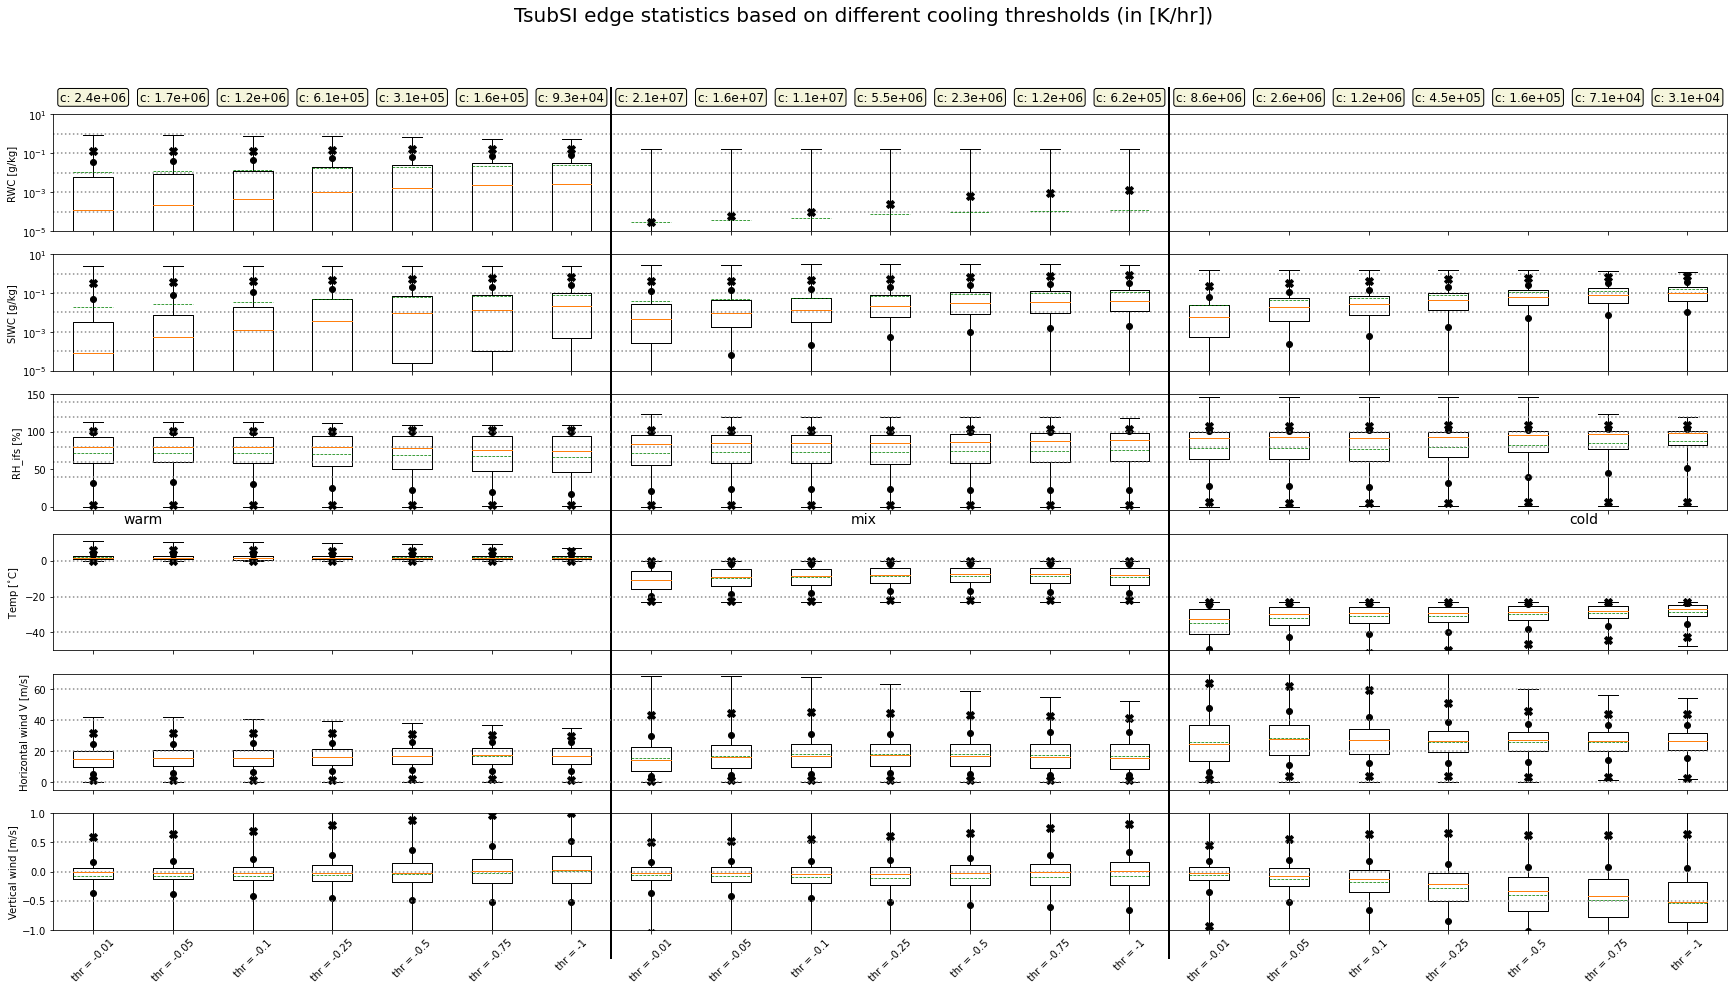

In [350]:
#df_stats_rwc, df_stats_siwc, df_stats_rh, df_stats_temp, df_stats_V, df_stats_W

dfs_rwc  = [df_dict_subsi_warm[0], df_dict_subsi_mix[0], df_dict_subsi_cold[0]]
dfs_siwc = [df_dict_subsi_warm[1], df_dict_subsi_mix[1], df_dict_subsi_cold[1]]
dfs_rh   = [df_dict_subsi_warm[2], df_dict_subsi_mix[2], df_dict_subsi_cold[2]]
dfs_temp = [df_dict_subs## Load data
ds_p = xr.open_mfdataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/P_p*_lonlatbox.nc')
ds_s = xr.open_mfdataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/S_p*_lonlatbox.nc')
ds_cc = xr.open_mfdataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/additional_fields/CC_p*.nc')
da_rh = xr.open_dataset('/home/freimax/msc_thesis/data/case_study_ra19/ifs_17/additional_fields/RH_ifs.nc')
# Get rid of last timestep (since this one is missing in ds_p)
da_rh = da_rh.isel(time=slice(0,-1))*100

ds_p['tsubsi'] = ds_p['tsubi'] + ds_p['tsubs']
ds_p['tmeltsi'] = ds_p['tmelti'] + ds_p['tmelts']
ds_p['SIWC'] = ds_p['IWC'] + ds_p['SWC']_thesis/figures/case_study_RA19/edge_field_stats/tsubsi.png'

plot_custom_boxplots(dfs_rwc, dfs_siwc, dfs_rh, dfs_temp, dfs_V, dfs_W, bcp_process='TsubSI', path=path)


In [241]:
cooling_thresholds = [-0.01, -0.05, -0.1, -0.25, -0.5, -0.75, -1,]
df_dict_meltsi_warm = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tmeltsi', temp_range='warm')
df_dict_meltsi_mix  = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tmeltsi', temp_range='mix')
df_dict_meltsi_cold = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tmeltsi', temp_range='cold')

Warm temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1
Mixed temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1
Cold temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1


In [302]:
## Safe dataframe
path = '/home/freimax/msc_thesis/data/case_study_ra19/edge_field_stats/tmeltsi'
with open(f'{path}/df_dict_meltsi_warm.pkl', 'wb') as f:
    pickle.dump(df_dict_meltsi_warm, f)

with open(f'{path}/df_dict_meltsi_mix.pkl', 'wb') as f:
    pickle.dump(df_dict_meltsi_mix, f)

with open(f'{path}/df_dict_meltsi_cold.pkl', 'wb') as f:
    pickle.dump(df_dict_meltsi_cold, f)


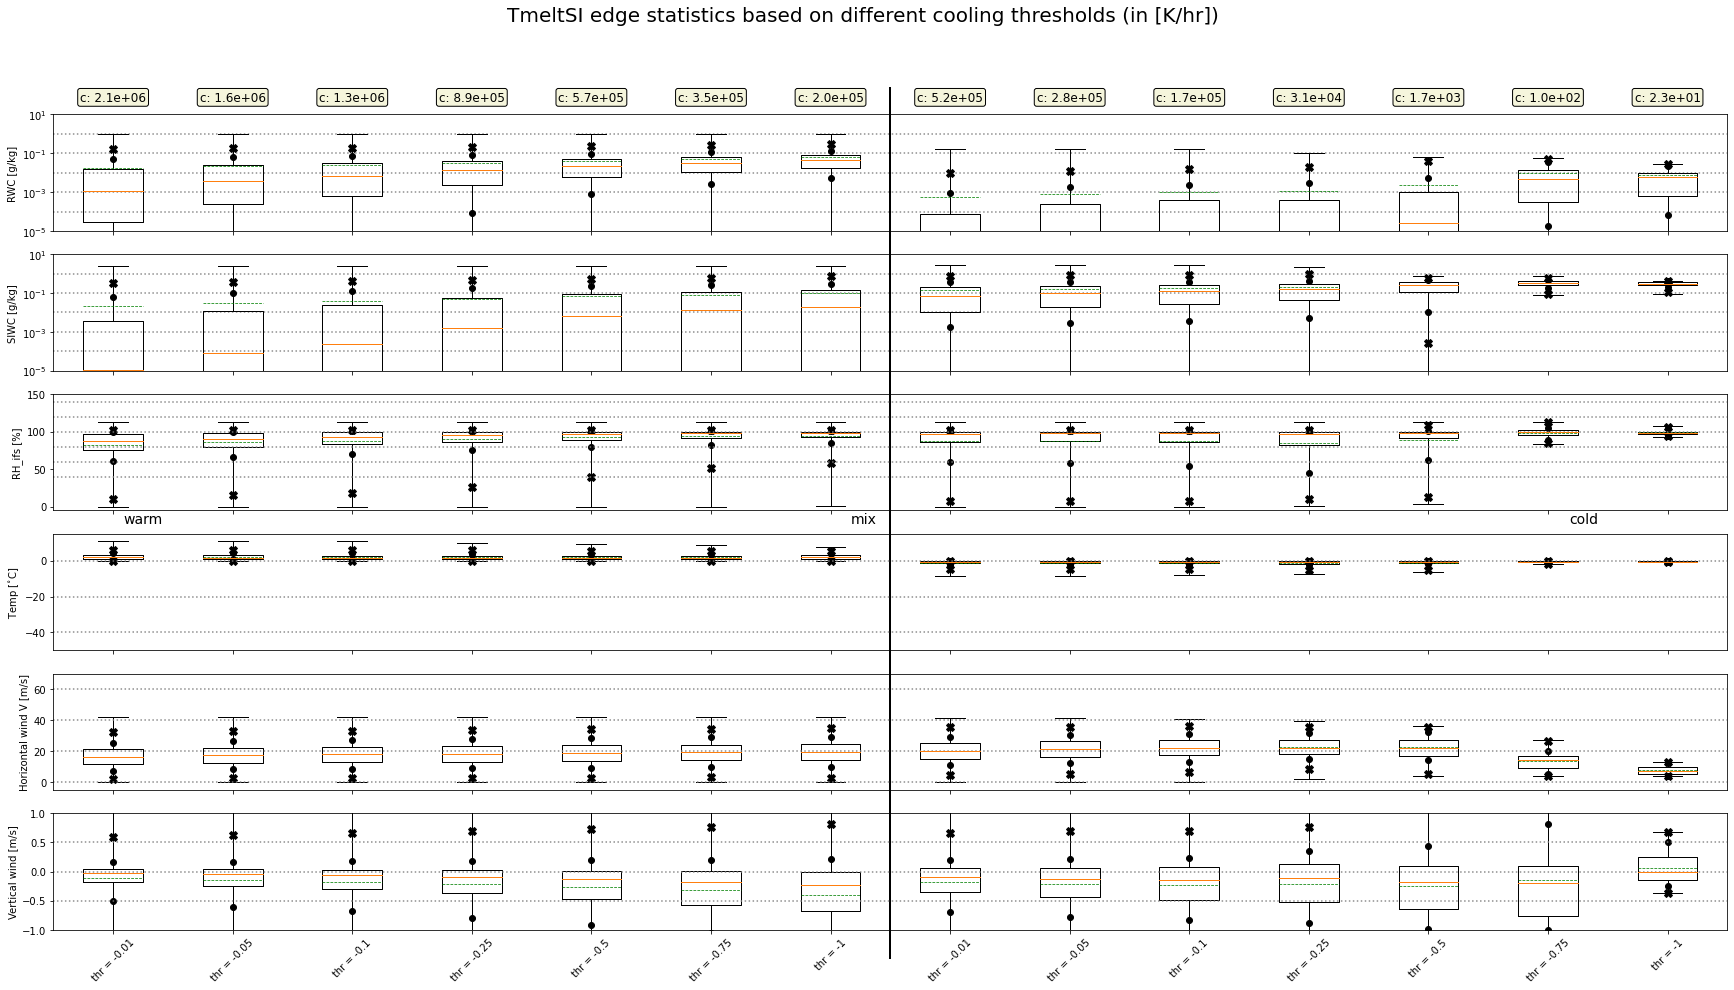

In [352]:
#df_stats_rwc, df_stats_siwc, df_stats_rh, df_stats_temp, df_stats_V, df_stats_W

dfs_rwc  = [df_dict_meltsi_warm[0], df_dict_meltsi_mix[0]]#, df_dict_meltsi_cold[0]]
dfs_siwc = [df_dict_meltsi_warm[1], df_dict_meltsi_mix[1]]#, df_dict_meltsi_cold[1]]
dfs_rh   = [df_dict_meltsi_warm[2], df_dict_meltsi_mix[2]]#, df_dict_meltsi_cold[2]]
dfs_temp = [df_dict_meltsi_warm[3], df_dict_meltsi_mix[3]]#, df_dict_meltsi_cold[3]]
dfs_V    = [df_dict_meltsi_warm[4], df_dict_meltsi_mix[4]]#, df_dict_meltsi_cold[4]]
dfs_W    = [df_dict_meltsi_warm[5], df_dict_meltsi_mix[5]]#, df_dict_meltsi_cold[5]]

path = '/home/freimax/msc_thesis/figures/case_study_RA19/edge_field_stats/tmeltsi.png'
plot_custom_boxplots(dfs_rwc, dfs_siwc, dfs_rh, dfs_temp, dfs_V, dfs_W, bcp_process='TmeltSI', path=path)

In [242]:
cooling_thresholds = [-0.01, -0.05, -0.1, -0.25, -0.5, -0.75, -1,]
df_dict_evr_warm = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tevr', temp_range='warm')
df_dict_evr_mix  = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tevr', temp_range='mix')
df_dict_evr_cold = create_bcp_threshold_df(cooling_thresholds=cooling_thresholds, bcp='tevr', temp_range='cold')

Warm temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1
Mixed temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1
Cold temperature range
Threshold: -0.01
Threshold: -0.05
Threshold: -0.1
Threshold: -0.25
Threshold: -0.5
Threshold: -0.75
Threshold: -1


In [353]:
## Safe dataframe
path = '/home/freimax/msc_thesis/data/case_study_ra19/edge_field_stats/tevr'
with open(f'{path}/df_dict_evr_warm.pkl', 'wb') as f:
    pickle.dump(df_dict_evr_warm, f)

with open(f'{path}/df_dict_evr_mix.pkl', 'wb') as f:
    pickle.dump(df_dict_evr_mix, f)

with open(f'{path}/df_dict_evr_cold.pkl', 'wb') as f:
    pickle.dump(df_dict_evr_cold, f)

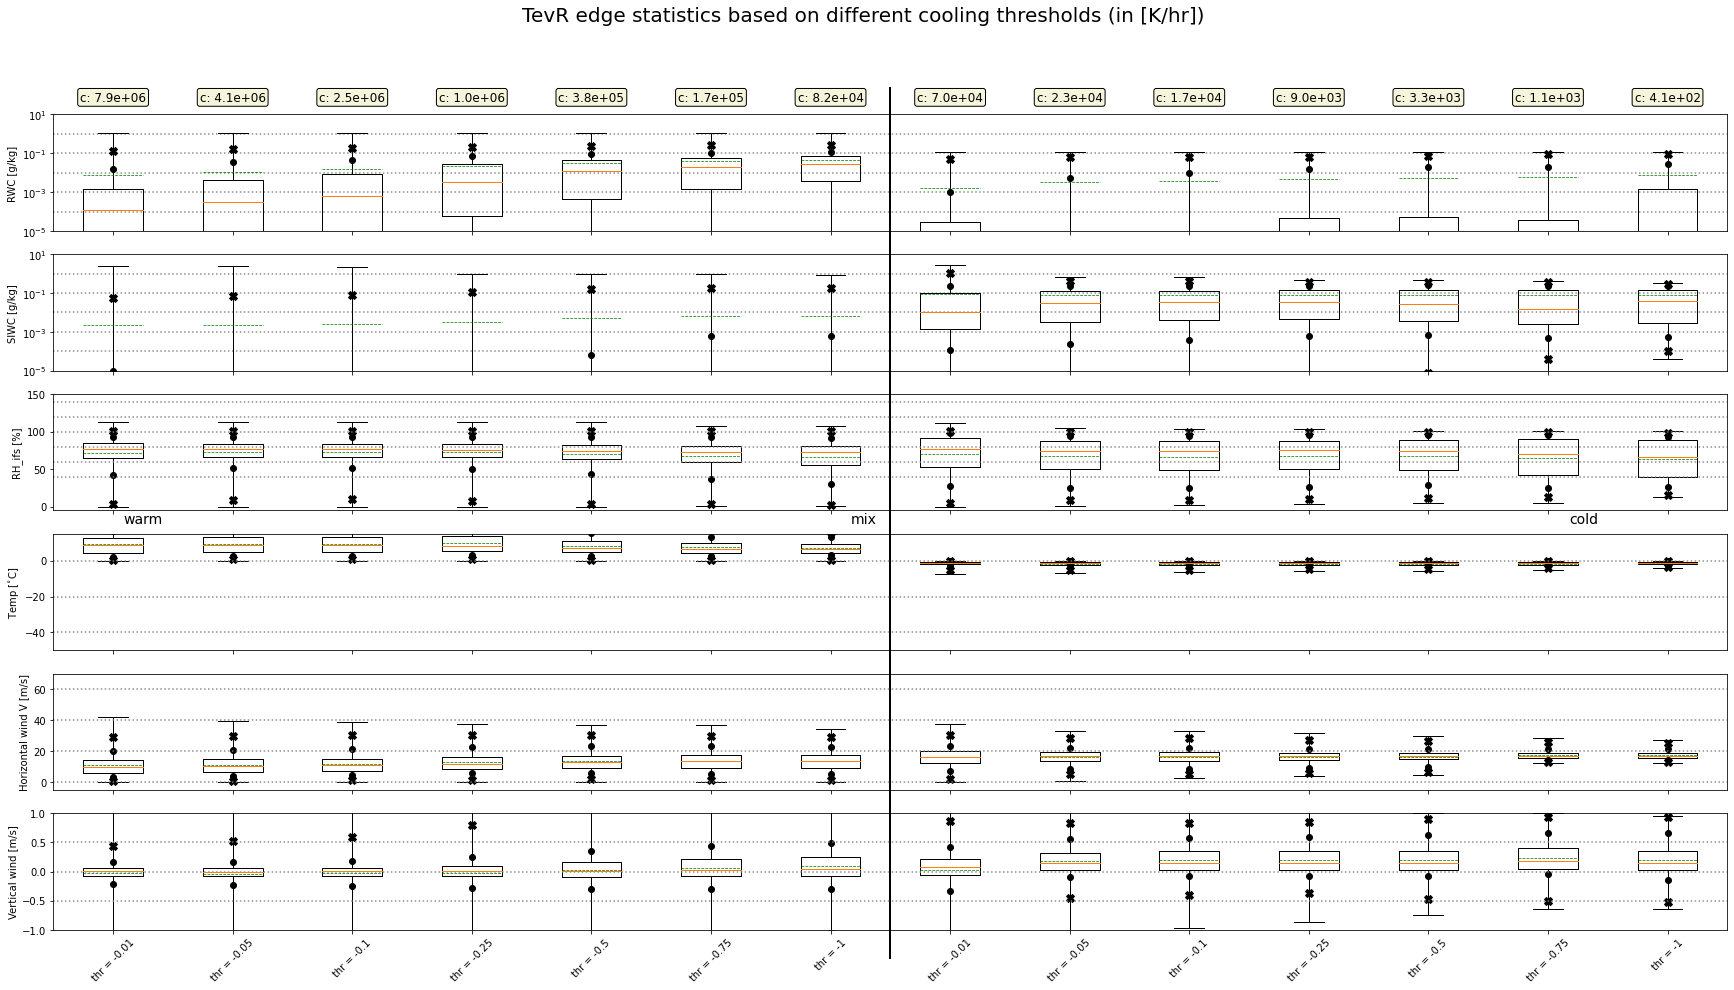

In [351]:
#df_stats_rwc, df_stats_siwc, df_stats_rh, df_stats_temp, df_stats_V, df_stats_W

dfs_rwc  = [df_dict_evr_warm[0], df_dict_evr_mix[0]]#, df_dict_evr_cold[0]]
dfs_siwc = [df_dict_evr_warm[1], df_dict_evr_mix[1]]#, df_dict_evr_cold[1]]
dfs_rh   = [df_dict_evr_warm[2], df_dict_evr_mix[2]]#, df_dict_evr_cold[2]]
dfs_temp = [df_dict_evr_warm[3], df_dict_evr_mix[3]]#, df_dict_evr_cold[3]]
dfs_V    = [df_dict_evr_warm[4], df_dict_evr_mix[4]]#, df_dict_evr_cold[4]]
dfs_W    = [df_dict_evr_warm[5], df_dict_evr_mix[5]]#, df_dict_evr_cold[5]]

path = '/home/freimax/msc_thesis/figures/case_study_RA19/edge_field_stats/tevr.png'
plot_custom_boxplots(dfs_rwc, dfs_siwc, dfs_rh, dfs_temp, dfs_V, dfs_W, bcp_process='TevR', path=path)

---

---
### Sobel edge on 2d cross-section
In this section we remove all bcp values that are unrelistically small (first guess -0.001 K/hr) and then apply sobel's edge detection and see what he finds

Ideas:
- Apply gaussian filter first
- Apply canny edge detection to get a smooth, thin edge

In [194]:
mask = (ds_p.tsubsi < -0.01)
data_field = ds_p.tsubsi.where(mask)
data_field

<xarray.DataArray 'tsubsi' (time: 72, level: 84, lat: 126, lon: 150)>
dask.array<where, shape=(72, 84, 126, 150), dtype=float32, chunksize=(18, 84, 126, 150), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2017-04-08T12:00:00 ... 2017-04-11T11:00:00
  * lon      (lon) float64 135.2 135.6 136.0 136.4 ... 193.6 194.0 194.4 194.8
  * lat      (lat) float32 20.0 20.4 20.8 21.2 21.6 ... 68.4 68.8 69.2 69.6 70.0
  * level    (level) int64 1030 1020 1010 1000 990 980 ... 240 230 220 210 200

In [168]:
def get_sobel_edge(data=ds_p['tsubsi'], tsubs_thr=-0.001, dimension=2):

    # Create the mask
    mask = (data < tsubs_thr)
    # Convert 0 values in the mask to NaN
    data_field = data.where(mask)

    # Multiply the original field by the mask
    #data_field = data * mask

    if dimension == 2:
        # Apply the Sobel operator for edge detection
        sobel_x = ndimage.sobel(data_field, axis=1)  # Gradient along the X-axis
        sobel_y = ndimage.sobel(data_field, axis=2)  # Gradient along the Y-axis
        # Calculate the magnitude of the gradient
        sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2 )
    elif dimension ==3:
        # Apply the Sobel operator for edge detection
        sobel_x = ndimage.sobel(data_field, axis=0)  # Gradient along the X-axis
        sobel_y = ndimage.sobel(data_field, axis=1)  # Gradient along the Y-axis
        sobel_z = ndimage.sobel(data_field, axis=2)  # Gradient along the Z-axis
        # Calculate the magnitude of the gradient
        sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2 + sobel_z ** 2)
        
    # Create a binary mask of edges
    edge_mask = (sobel_magnitude > 0).astype(int)
    return edge_mask, data_field


def get_bcp_edge(data=ds_p['tsubsi'], cooling_threshold=-0.01, dimension=2):
    # Create a binary mask of non-zero tsubS values
    tsubS_mask = (data < cooling_threshold).astype(int)

    if dimension == 2:
        # Apply the Sobel operator for edge detection
        sobel_x = ndimage.sobel(tsubS_mask, axis=0)  # Gradient along the X-axis
        sobel_y = ndimage.sobel(tsubS_mask, axis=1)  # Gradient along the Y-axis
        # Calculate the magnitude of the gradient
        sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    elif dimension ==3:
        # Apply the Sobel operator for edge detection
        sobel_x = ndimage.sobel(tsubS_mask, axis=0)  # Gradient along the X-axis
        sobel_y = ndimage.sobel(tsubS_mask, axis=1)  # Gradient along the Y-axis
        sobel_z = ndimage.sobel(tsubS_mask, axis=2)  # Gradient along the Z-axis
        # Calculate the magnitude of the gradient
        sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2 + sobel_z ** 2)
        
    # Create a binary mask of edges
    edge_mask = (sobel_magnitude > 0).astype(int)
    return edge_mask

In [178]:
edge_mask_ds_p = get_sobel_edge(data=ds_p['tsubsi'], tsubs_thr=-0.1)[0]


In [179]:
# Prepare cross-section data to plot fields
start = (33.0, 162.5)
end   = (49.0, 174.5)
timestep='20170410-17'

data_p  =  get_cross_section_data(start=start, end=end, timestep=timestep).get('data_p')
cross_p =  get_cross_section_data(start=start, end=end, timestep=timestep).get('cross_p')

tsubs_thr=-0.1
edge_mask = get_sobel_edge(data=cross_p.tsubsi, tsubs_thr=tsubs_thr)[0]
cross_p_subsi = get_sobel_edge(data=cross_p.tsubsi, tsubs_thr=tsubs_thr)[1]

edge_mask1 = get_bcp_edge(data=cross_p.tsubsi, cooling_threshold=tsubs_thr)

In [171]:
cross_p.data_vars

Data variables:
    Q        (level, index) float32 dask.array<chunksize=(84, 100), meta=np.ndarray>
    RH       (level, index) float32 dask.array<chunksize=(84, 100), meta=np.ndarray>
    RWC      (level, index) float32 dask.array<chunksize=(84, 100), meta=np.ndarray>
    LWC      (level, index) float32 dask.array<chunksize=(84, 100), meta=np.ndarray>
    IWC      (level, index) float32 dask.array<chunksize=(84, 100), meta=np.ndarray>
    SWC      (level, index) float32 dask.array<chunksize=(84, 100), meta=np.ndarray>
    T        (level, index) float32 dask.array<chunksize=(84, 100), meta=np.ndarray>
    OMEGA    (level, index) float32 dask.array<chunksize=(84, 100), meta=np.ndarray>
    U        (level, index) float32 dask.array<chunksize=(84, 100), meta=np.ndarray>
    V        (level, index) float32 dask.array<chunksize=(84, 100), meta=np.ndarray>
    tcond    (level, index) float32 dask.array<chunksize=(84, 100), meta=np.ndarray>
    tdep     (level, index) float32 dask.array<ch

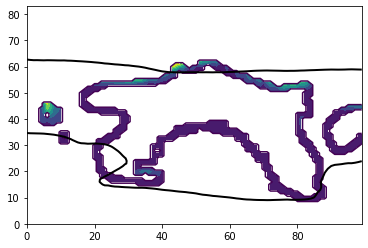

In [180]:
plt.contour(edge_mask1,levels=[0.5])
edge_mask11=edge_mask1.astype('float')
edge_mask11[edge_mask11==0]=np.nan

plt.contour(cross_p.T, levels=[-23,0], colors='k', linewidths=2, linestyles='-')

plt.contourf(edge_mask11*cross_p.IWC)

/tmp/ipykernel_12483/1422528376.py:11: UserWarning: No contour levels were found within the data range.
  ax.contour(cross_p['lon'], cross_p['level'], edge_mask1, levels=[1], linewidths=1.5, )


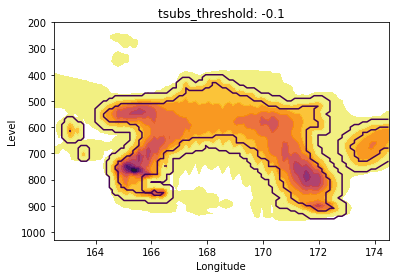

In [181]:

fig, ax = plt.subplots()


# Plot the corresponding SIWC values using contour lines
#(edge_mask * cross_p['SIWC']).plot(ax=ax)
#(edge_mask * cross_p['RH_ifs']).plot(ax=ax)

# Plot the corresponding RH values using contour lines
img=ax.contourf(cross_p['lon'], cross_p['level'], cross_p['tsubsi'], cmap='inferno', levels=np.linspace(cross_p['tsubs'].min(), -0.01, 11), alpha=0.9)

ax.contour(cross_p['lon'], cross_p['level'], edge_mask1, levels=[1], linewidths=1.5, )

ax.set_title(f'tsubs_threshold: {tsubs_thr}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Level')
#ax.set_title('Cross-section of RH and SIWC along the edge of non-zero tsubS values')
ax.invert_yaxis()
plt.show()

---
---
## Find a good threshold for cooling rates

In [183]:
tsubsi= ds_p.tsubsi.values.flatten()
tevr = ds_p.tevr.values.flatten()

Text(0, 0.5, 'Occurence')

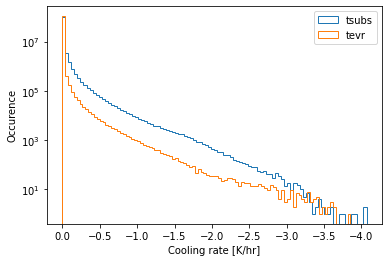

In [184]:
fig, ax = plt.subplots()

img1 = ax.hist(tsubsi, bins=100, density=False, histtype='step', log=True, label='tsubs')
img2 = ax.hist(tevr, bins=100, density=False, histtype='step', log=True, label='tevr')

ax.invert_xaxis()
ax.legend()

ax.set_xlabel('Cooling rate [K/hr]')
ax.set_ylabel('Occurence')

Text(0, 0.5, 'Occurence')

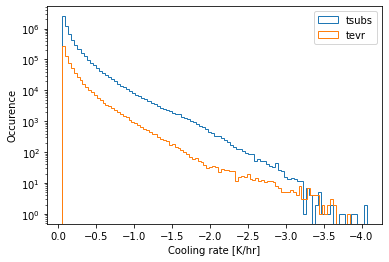

In [187]:
fig, ax = plt.subplots()

img1 = ax.hist(tsubsi[tsubsi<=-0.05], bins=100, density=False, histtype='step', log=True, label='tsubs')
img2 = ax.hist(tevr[tevr<=-0.05], bins=100, density=False, histtype='step', log=True, label='tevr')

ax.invert_xaxis()
ax.legend()

ax.set_xlabel('Cooling rate [K/hr]')
ax.set_ylabel('Occurence')

---
---